In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sn
import chess
import chess.uci
import chess.pgn
import io

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
X=pd.read_table('all_with_filtered_anotations_since1998.txt',
                sep=' ',usecols = np.arange(16),engine='c',
               skiprows=[0,1,2,3,4],
                names=['t','date','result','welo','belo','len',
                       'date_c','resu_c','welo_c','belo_c','edate_c','setup','fen','resu2_c','oyrange','bad_len'],
                na_values='None',
                nrows=100000,
               )

In [4]:
def str2bool(k):
    if k=='true': return True
    if k=='false': return False
    return k

In [5]:
X = X.apply(lambda st: pd.Series(str2bool(s.split('_')[-1]) if isinstance(s,str) else s for s in st ),axis=0)

In [6]:
Z=pd.read_table('all_with_filtered_anotations_since1998.txt',
                sep='### ',
                skiprows=[0,1,2,3,4],
                names=['garbage','game'],
                na_values='None',
                nrows=1000,
                )['game']

/home/marc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [7]:
Z[10]

'W1.e4 B1.c5 W2.Nf3 B2.Nc6 W3.d4 B3.cxd4 W4.Nxd4 B4.Nf6 W5.Nc3 B5.e5 W6.Ndb5 B6.d6 W7.Bg5 B7.a6 W8.Na3 B8.b5 W9.Bxf6 B9.gxf6 W10.Nd5 B10.f5 W11.c3 B11.Bg7 W12.exf5 B12.Bxf5 W13.Nc2 B13.Be6 W14.a4 B14.O-O W15.axb5 B15.axb5 W16.Rxa8 B16.Qxa8 W17.Nce3 B17.Qb7 W18.g4 B18.Ne7 W19.Bg2 B19.Nxd5 W20.Bxd5 B20.Qe7 W21.h4 B21.Rc8 W22.g5 B22.Rc5 W23.Be4 B23.d5 W24.Nxd5 B24.Bxd5 W25.Bxd5 B25.e4 W26.Ke2 B26.Qe5 W27.Bb3 B27.Qc7 W28.Qg1 B28.b4 W29.g6 B29.hxg6 W30.Qxg6 B30.Kf8 W31.Qg3 B31.Qxg3 W32.fxg3 B32.bxc3 W33.bxc3 B33.Rxc3 W34.Bd5 B34.Rxg3'

In [58]:
G = chess.pgn.read_game(io.StringIO(Z[100]))

In [65]:
handler = chess.uci.InfoHandler()
engine = chess.uci.popen_engine('./stockfish-10-linux/Linux/stockfish_10_x64')
engine.info_handlers.append(handler)
for i,g in enumerate(G.mainline()):
    engine.position(g.board())
    evaluation = engine.go(movetime=400)
    print(g.board().turn)
    print(evaluation.bestmove.uci())
    print(handler.info["score"][1].cp)

False
d7d5
2
True
c2c4
61
False
e7e6
0
True
b1c3
94
False
c7c6
30
True
f1g2
83
False
c7c5
-11
True
c4d5
85
False
f6d5
-29
True
g1f3
69
False
d5b4
-38
True
g1e2
89
False
c7c5
-16
True
e1g1
86
False
b8a6
-33
True
f2f4
151
False
e7e5
-27
True
d4d5
170
False
f7f5
-140
True
f2f4
225
False
b6c4
-184
True
b2b3
262
False
c8f5
-166
True
c1e3
349
False
c8f5
-229
True
h2h3
367
False
f7f6
-213
True
h2h3
324
False
g4d7
-268
True
d1e2
378
False
b6d7
-337
True
a1c1
382
False
b7b5
-296
True
c3e4
348
False
a5b5
-304
True
d1b1
358
False
f7e6
-397
True
d5e6
434
False
d7f6
-404
True
e4c5
426
False
a5b6
-432
True
e2f2
432
False
f8e6
-248
True
g1h2
528
False
h5f6
-397
True
g3g4
596
False
h5f6
-573
True
f4f5
621
False
c3c7
-573
True
f4f5
660
False
e7f6
-405
True
g4g5
382
False
e7f6
-323
True
f4f5
374
False
a3e7
-335
True
g2b7
380
False
c8c5
-366
True
d1d6
393
False
c5e5
-395
True
f1c1
472
False
e8e7
-493
True
g4f5
599
False
f8e6
-601
True
g2d5
639
False
g8g7
-639
True
c1c7
931
False
f8h7
-730
True
c1c8
822
F

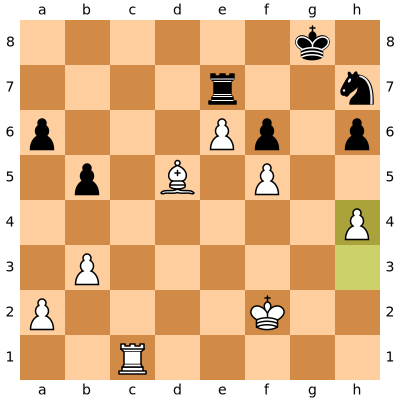

In [66]:
g.board()

In [68]:
g.board().turn*2-1


-1

f7e6
0


In [ ]:
with_elos = X[~X['welo_c']&~X['belo_c']]
elos = with_elos['welo']-with_elos['belo']


In [ ]:
def result2score(result_str):
    if result_str == '1/2-1/2': return 0
    if result_str == '1-0':return 1
    if result_str == '0-1':return -1
scores = with_elos['result'].apply(result2score)

In [ ]:
Y = pd.DataFrame({'elo_gap':elos,'scores':scores})

In [ ]:
#Y = pd.DataFrame(elos[scores==i] for i in [-1,0,1])

In [ ]:
# rolls_dict = {i:elos[Y['scores']==i] for i in [-1,0,1]}

# #You can print the next line to see what rolls_dict is
# #print(rolls_dict) 

# #put the dictionary into a DataFrame
# #means = pd.DataFrame(rolls_dict)
# #means.plot.hist(stacked=True,bins=20,density=True,kde=True)
# for col in [-1,0,1]:
#     sn.distplot(rolls_dict[col],kde=True,label=col)
# plt.xlim(-100,550)
# plt.legend()
# #the bar plot takes means as the data, and ci tells it 
# #what confidence interval to plot with.
# #sns.distplot(means) 
# #sns.set(style="whitegrid")
# #plt.ylabel('Proportion of rolls')
# #plt.xlabel('Dice outcome')

In [ ]:
#sn.catplot(x="scores", y="elo_gap", kind="swarm", data=Y);

In [ ]:
sn.regplot(elos,scores)

In [ ]:
Y['scores'].values

In [ ]:
Y['elo_gap'].values

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data
from oil.model_trainers.trainer import Trainer
x = torch.from_numpy(Y['elo_gap'].values.astype(np.float32)).unsqueeze(-1)
y = torch.from_numpy(Y['scores'].values.astype(np.float32)).unsqueeze(-1)
train = torch.utils.data.TensorDataset(x,y)
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True,drop_last=True)
class Regressor(Trainer):
    def loss(self, mb):
        x,y = mb
        return nn.MSELoss()(self.model(x),y)


l_rate = 0.001

model = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.Linear(1, 1),
            nn.Tanh()
        )
dataloaders={'train':train_loader}
log_args={'no_print':True, 'minPeriod':0, 'timeFrac':.2}
opt_constr = lambda params: torch.optim.Adam(params,lr=1e-4) 
trainer = Regressor(model,dataloaders,log_args=log_args)#,opt_constr=opt_constr)

In [ ]:
trainer.train(10);

In [ ]:
trainer.model.eval()
trainer.logger.scalar_frame.plot()

In [ ]:
x = np.linspace(-600,500,1000)
x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(-1)

In [ ]:
y_pred = trainer.model(x_t).squeeze(-1).data.numpy()

In [ ]:
trainer.model(torch.zeros(1,1)-50)

In [ ]:
plt.plot(x,y_pred)

In [ ]:
X.hist('welo')
X.hist('belo')

In [ ]:
sn.distplot(X['belo'])

In [ ]:
X